In [2]:
import pandas as pd
import datetime
import numpy as np
import sklearn
import copy
import tensorflow as tf
import keras
import matplotlib.pyplot as pl
import io 
import matplotlib.pyplot as plt

### Loading the datasets

In [9]:
# please load your own path here
combined_df=pd.read_csv(r'/Users/yipjh/Desktop/Projects/Predicting-Dengue-in-Singapore/Data/post-processed/combined_data_030120.csv')
dengue_df=pd.read_csv(r'/Users/yipjh/Desktop/Projects/Predicting-Dengue-in-Singapore/Data/post-processed/dengue_271219.csv')
pop_df=pd.read_csv(r'/Users/yipjh/Desktop/Projects/Predicting-Dengue-in-Singapore/Data/post-processed/population-sg.csv')

### Cleaning the data

In [10]:
pop_dict={}
for i, j in pop_df.iterrows():
    pop_dict.update({j[0]:int(j[1].replace(',',''))})

pop_df['population']=pop_dict.values()

oo=pd.date_range('1/2/2000', periods=7273)
date_list=oo.to_pydatetime().tolist()

op=dengue_df['Unnamed: 0']
def foo(st):
 y=st.split('-')
 return datetime.datetime(int(y[0]), int(y[1]), int(y[2]))

dt_list=list(map(foo, op))
oo=oo.to_pydatetime().tolist()
combined_df.index=oo

combined_df.drop(['Unnamed: 0'], axis=1, inplace=True)
dengue_df.drop(['Unnamed: 0'], axis=1, inplace=True)

dengue_df.index=dt_list

In [11]:
# to get rid of duplicates in the dengue dataset
def rid_duplicates(df):
    return df.loc[~df.index.duplicated(keep='first')]

trancated_dengue=rid_duplicates(dengue_df)

In [12]:
# we want to normalise the data first
def normaliser(df, *args):
    _=copy.copy(df)
    for i in args:
        ran=_[i].max()-_[i].min()
        std=_[i].std()
        ave=_[i].mean()
        _[i]=(_[i]-ave)/std
    return _

In [13]:
trancated_dengue=normaliser(trancated_dengue, 'dengue')
combined_df=normaliser(combined_df, 'rain_mean', 'temp_mean')
pop_df=normaliser(pop_df, 'population')

In [14]:
def pull_dataframe(date, x, iu, *args, **kwargs):
    idx=date_list.index(date)
    u=pd.DataFrame()
    if idx-x-iu>0:
        for i, text in zip(args, kwargs.values()):
            o=i[idx-x-iu:idx-iu][text]
            u[text]=o
        return u, date
    else:
        return u, date

In [15]:
rainfall_df=pd.DataFrame(combined_df['rain_mean'])
temperature_df=pd.DataFrame(combined_df['temp_mean'])

### Setting parameters of our inputs
`DATA_WINDOW` refers to the number of weeks of data considered when making the prediction of dengue cases.

`LEAD_TIME` refers to how many weeks in the future we are doing our dengue prediction.

`MAX_EXTRACT` and `LCD` will be dealt with below. 

In [16]:
DATA_WINDOW=16 #should be even
LEAD_TIME=8
MAX_EXTRACT=20 # rainfall window
LCD=6 #should divide DATA_WINDOW or 7, increase to reduce noise

In [17]:
rf_df=pd.DataFrame()
tp_df=pd.DataFrame()

for date in trancated_dengue.index:
    if date in date_list:
        df_pushback, dat=pull_dataframe(date, DATA_WINDOW*7, LEAD_TIME*7, rainfall_df, temperature_df, label1='rain_mean', label2='temp_mean')
    if len(df_pushback)!=0:
        rf_df[dat]=df_pushback['rain_mean'].values
        tp_df[dat]=df_pushback['temp_mean'].values

For instance, to do prediction on the dengue cases in 2000-06-19, rainfall and temperature data from 8-24 weeks back are used. This gives us a 112 days of rainfall and temperature data, which are indexed 0-111 down the columns in both the `rf_df` and `tp_df` dataframe.

In [26]:
rf_df.shape

(112, 1011)

In [25]:
rf_df.head()

,2000-06-19,2000-06-26,2000-07-03,2000-07-10,2000-07-17,2000-07-24,2000-07-31,2000-08-07,2000-08-14,2000-08-21,...,2019-09-23,2019-09-30,2019-10-07,2019-10-14,2019-10-21,2019-10-28,2019-11-04,2019-11-11,2019-11-18,2019-11-25
0,-0.310010,-0.073947,3.517442,0.041939,0.111685,0.490103,0.227571,0.522293,-0.196628,-0.586133,...,-0.547973,-0.587407,-0.453151,0.010320,-0.592214,0.084418,-0.493584,-0.467996,2.402074,-0.533702
1,-0.538921,-0.314302,-0.212366,4.049301,0.213264,-0.090042,-0.570038,2.154710,-0.592214,-0.592214,...,0.056646,-0.497445,1.280273,-0.480978,-0.318208,0.090138,-0.465028,-0.544075,-0.301868,1.094485
2,3.938065,2.648656,-0.458087,-0.573973,-0.449145,0.259404,-0.592214,-0.014215,-0.399428,-0.592214,...,0.077174,-0.522840,-0.242273,-0.591184,4.154639,0.093992,-0.088903,-0.105665,-0.526974,1.554999
3,-0.405151,-0.492423,-0.591141,-0.558235,-0.546432,-0.403721,0.174636,0.164979,-0.529979,-0.554301,...,-0.168014,-0.475613,0.077540,-0.294688,-0.587063,0.078780,-0.561311,0.755671,0.516213,-0.197175
4,-0.575761,-0.546789,-0.592214,-0.465956,-0.592214,0.246886,0.553053,-0.351143,-0.559308,-0.592214,...,-0.497252,-0.065778,3.550218,-0.434437,0.905455,0.226825,-0.592214,-0.371709,1.049969,-0.436049


### Noise Reduction

The rainfall daily and temperature data are noisy. As explained in the medium article, we will be focusing on the maximum $n$ days, as well as other metrics (such as mean and std) to reduce the noise.

`MAX_EXTRACT`=$n$. Takes out the maximum $n$ rainfall/temperature data down each column.

`LCD`=$d$. Takes an interval of $d$ days from the `DATA_WINDOW*7=112` days and averages it.

In [28]:
def extract_max(df, n , label):
  size=np.argsort(df.values, axis=0)[-n:].T.shape
  ref=np.argsort(df.values, axis=0)[-n:]
  # rainfall_values=rf_df.values.T
  maximum_values=np.zeros((size[0], n))

  for i in range(size[0]):
    for j in range(n):
      pos=ref.T[i][j]
      val=df.values[pos][i]
      maximum_values[i, j]=val

  columns_list=[]
  for i in range(1, n+1):
    columns_list.append(label+str(i))

  maximum_df=pd.DataFrame(maximum_values, columns=columns_list)
  return maximum_df

maximum_rainfall_df=extract_max(rf_df, MAX_EXTRACT, 'rainfallmax')
maximum_temperature_df=extract_max(tp_df, MAX_EXTRACT, 'temperaturemax')

In [29]:
def seven_day_mean(n, d, **kwargs): # where d should be a divisor of n, chooose d smaller for more 'rugged' data
    a=pd.DataFrame()
    for j, df in zip(kwargs.keys(), kwargs.values()):
        for i in range(0, n , d):
            label=str(j)+str( i)
            a[label]=df[i:i+d].mean(axis=0)
    return a

In [35]:
df_seven_day_mean=seven_day_mean(DATA_WINDOW*7, LCD, mean_rain=rf_df, mean_temp=tp_df)

In [36]:
# for rainfall/temp metrics such as max, min, std, med
mean_df=pd.DataFrame()

mean_df['temp_mean']=list(tp_df.mean(axis=0))
mean_df['temp_std']=list(tp_df.std(axis=0))
mean_df['temp_min']=list(tp_df.min(axis=0))
mean_df['temp_max']=list(tp_df.max(axis=0))
mean_df['temp_med']=list(tp_df.median(axis=0))

mean_df['rain_mean']=list(rf_df.mean(axis=0))
mean_df['rain_std']=list(rf_df.std(axis=0))
mean_df['rain_min']=list(rf_df.min(axis=0))
mean_df['rain_max']=list(rf_df.max(axis=0))
mean_df['rain_med']=list(rf_df.median(axis=0))

In [37]:
mean_df=mean_df.merge(maximum_rainfall_df, left_index=True, right_index=True)
mean_df=mean_df.merge(maximum_temperature_df, left_index=True, right_index=True)

In [38]:
indexes=df_seven_day_mean.index
df_seven_day_mean.reset_index(drop=True, inplace=True)
mean_df.reset_index(drop=True, inplace=True)

In [39]:
def merge(a, b):
    indexes=a.index
    a.reset_index(drop=True, inplace=True)
    b.reset_index(drop=True, inplace=True)
    for col in b.columns:
        a[col]=b[col]
    a.index=indexes
    return a

mean_df=merge(mean_df, df_seven_day_mean)
mean_df.index=indexes
combined_Data=mean_df

In [40]:
dengue_append=trancated_dengue[trancated_dengue.index>=combined_Data.index[0]]

In [41]:
combined_Data['dengue_actual']=dengue_append['dengue']

### Adding population data 

In [42]:
pop_df=pop_df[pop_df['year']>=2000]
a=[]
for i in combined_Data.index:
    a.append(pop_dict[i.year])

combined_Data['population']=a

### Adding past dengue data

This section adds past dengue data prior to the actual date which we wish to predict. For instance, if we wish to predict dengue cases in week $24$ with a lead time of $8$, dengue cases from week $1-16$ are included.

In [44]:
def shift(df, data_window, lead_time):
  dengue_shift=pd.DataFrame()
  for i in range(data_window+lead_time+1):
      dengue_shift[-i]=list(df['dengue'].shift(i))
  for i in range(LEAD_TIME+1):
    dengue_shift.drop([-i], axis=1, inplace=True)
  dengue_shift=dengue_shift.dropna()
  return dengue_shift

In [45]:
dengue_shift=shift(trancated_dengue, DATA_WINDOW, LEAD_TIME)

In [48]:
# here, -9 indicates the most recent data and -24 incidcates the most outdated data, ie 15 weeks before week -9. 
# The week which we wish to predict is considered week 0 which corresponds to a lead time of 8.
dengue_shift.head()

,-9,-10,-11,-12,-13,-14,-15,-16,-17,-18,-19,-20,-21,-22,-23,-24
24,-1.008324,-1.008324,-1.035955,-1.022139,-0.980693,-1.042862,-0.987601,-0.966878,-0.953062,-1.029047,-0.932339,-0.973785,-0.959970,-0.959970,-0.994508,-0.946154
25,-0.980693,-1.008324,-1.008324,-1.035955,-1.022139,-0.980693,-1.042862,-0.987601,-0.966878,-0.953062,-1.029047,-0.932339,-0.973785,-0.959970,-0.959970,-0.994508
26,-0.987601,-0.980693,-1.008324,-1.008324,-1.035955,-1.022139,-0.980693,-1.042862,-0.987601,-0.966878,-0.953062,-1.029047,-0.932339,-0.973785,-0.959970,-0.959970
27,-1.015231,-0.987601,-0.980693,-1.008324,-1.008324,-1.035955,-1.022139,-0.980693,-1.042862,-0.987601,-0.966878,-0.953062,-1.029047,-0.932339,-0.973785,-0.959970
28,-0.973785,-1.015231,-0.987601,-0.980693,-1.008324,-1.008324,-1.035955,-1.022139,-0.980693,-1.042862,-0.987601,-0.966878,-0.953062,-1.029047,-0.932339,-0.973785


This averages specific columns from the `dengue_shift` dataframe. `ave2` takes in the 2 most recent data entries and averages them. (ie. from -9 to -10). `ave4` takes in the 4 most recent entries and does the same. (ie. from -9 to -13). This tries to reduce noise in the dengue dataset without completely getting rid of it.

In [49]:
def average_last_n_cols(df, *args):
  df_average=pd.DataFrame()
  c= copy.copy(df)
  for n in args:
    f=c[c.columns[0:n]]
    average_n=f.mean(axis=1)
    label='ave' + str(n)
    df_average[label]=average_n
  return df_average

In [50]:
ave_intevals=list(np.arange(2, DATA_WINDOW+2, 2))
dengue_average=average_last_n_cols(dengue_shift, *ave_intevals)

In [52]:
dengue_average.head()

,ave2,ave4,ave6,ave8,ave10,ave12,ave14,ave16
0,-1.008324,-1.018685,-1.016383,-1.006597,-1.003488,-0.995084,-0.990068,-0.987601
1,-0.994508,-1.008324,-1.006021,-1.008324,-0.998653,-0.995660,-0.991548,-0.989759
2,-0.984147,-0.996235,-1.007172,-1.008324,-1.002107,-1.000265,-0.993522,-0.989328
3,-1.001416,-0.997962,-1.006021,-1.004870,-1.006942,-0.999113,-0.996482,-0.992781
4,-0.994508,-0.989328,-0.995660,-1.004006,-1.005561,-1.000840,-0.999442,-0.993645


In [53]:
dengue_process=merge(dengue_shift, dengue_average)

### Adding dengue trends

`trend` is simply: (last week-first week)/DATA_WINDOW, and in our case: `(week[-9]-week[-24])/DATA_WINDOW)`.

`strong_trend` takes: (ave2-ave(DATA_WINDOW))/DATA_WINDOW, and in our case: `(ave2-ave16)/DATA_WINDOW)`.


In [55]:
def df_trend(df, lead_time, data_window):
  dengue_trend=pd.DataFrame()
  dengue_trend['trend']=(df[-data_window-lead_time]-dengue_shift[-lead_time-1])/data_window
  return dengue_trend

def df_str_trend(df, weak, strong, data_window):
  strong_trend=pd.DataFrame()
  weak_label='ave'+str(weak)
  strong_label='ave'+str(strong)
  strong_trend['strong_trend']=(df[strong_label]-dengue_shift[weak_label])/data_window
  return strong_trend

In [56]:
dengue_trend=df_trend(dengue_process, LEAD_TIME, DATA_WINDOW)
strong_trend=df_str_trend(dengue_process, 2, DATA_WINDOW, DATA_WINDOW)

In [57]:
dengue_process=merge(dengue_process, dengue_trend)
dengue_process=merge(dengue_process, strong_trend)
dengue_process['dengue_std']=list(dengue_shift.std(axis=1))

In [58]:
dengue_process_norm=normaliser(dengue_process, 'trend', 'strong_trend')

In [59]:
combined_Data=merge(dengue_process_norm, combined_Data)
combined_Data.index=indexes

In [60]:
combined_Data.head()

,-9,-10,-11,-12,-13,-14,-15,-16,-17,-18,...,mean_temp66,mean_temp72,mean_temp78,mean_temp84,mean_temp90,mean_temp96,mean_temp102,mean_temp108,dengue_actual,population
2000-06-19,-1.008324,-1.008324,-1.035955,-1.022139,-0.980693,-1.042862,-0.987601,-0.966878,-0.953062,-1.029047,...,-0.353033,-1.176515,-1.063192,-1.187848,-0.424804,-0.458801,-0.073502,-0.558904,-0.987601,4027887
2000-06-26,-0.980693,-1.008324,-1.008324,-1.035955,-1.022139,-0.980693,-1.042862,-0.987601,-0.966878,-0.953062,...,-1.112299,-1.078302,-1.044305,-0.557015,0.005824,-0.436137,-0.651451,-0.536239,-0.918524,4027887
2000-07-03,-0.987601,-0.980693,-1.008324,-1.008324,-1.035955,-1.022139,-0.980693,-1.042862,-0.987601,-0.966878,...,-1.010308,-0.772329,-0.727000,0.402455,-0.930982,-0.677893,-0.194380,-0.439914,-0.973785,4027887
2000-07-10,-1.015231,-0.987601,-0.980693,-1.008324,-1.008324,-1.035955,-1.022139,-0.980693,-1.042862,-0.987601,...,-0.647673,-0.840323,0.474227,-0.760997,-0.715667,-0.273707,0.353349,1.084284,-0.980693,4027887
2000-07-17,-0.973785,-1.015231,-0.987601,-0.980693,-1.008324,-1.008324,-1.035955,-1.022139,-0.980693,-1.042862,...,-0.893207,0.360904,-0.545683,-0.591012,-0.500353,0.579995,1.040843,1.203273,-0.973785,4027887


### Adding year month data

In [61]:
combined_Data['year']=combined_Data.index.year
combined_Data['month']=combined_Data.index.month
combined_Data['trend']=list(dengue_trend['trend'])

In [62]:
combined_Data=normaliser(combined_Data, 'year','month', 'population')

In [63]:
def move_dengue_actual_to_back(df):
 a=pd.DataFrame(df['dengue_actual'])
 df.drop(['dengue_actual'], axis=1, inplace=True)
 df['dengue_actual']=a
 return df

In [64]:
df_normalised=move_dengue_actual_to_back(combined_Data)

### Splitting the data
Into X (features) and y (labels) and into training the testing sets

In [66]:
X=df_normalised.drop('dengue_actual', axis=1)
Y=pd.DataFrame(df_normalised['dengue_actual'])

In [67]:
def euclid_loss(a,b):
    return np.mean((a-b)**2)

def baseline(df):
  a=df[-LEAD_TIME-1]
  b=df['dengue_actual']
  return euclid_loss(a,b), list(a), list(b)

In [68]:
ratio=0.90
train_size=int(len(X)*ratio)
test_size=int(len(X)*(1-ratio));
print(test_size)

101


### Baseline prediction
Involves shifting the graph `-LEAD_TIME` units and simply making predictions out of this shifted graph. This is the loss we will attempt to beat.

In [69]:
loss, pred, actual=baseline(df_normalised[-test_size:]); loss

1.0314973708352237

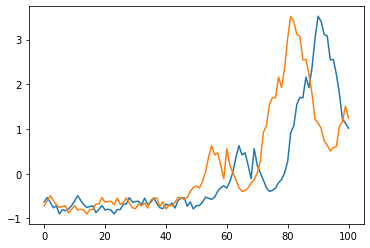

In [70]:
plt.plot(pred)
plt.plot(actual)
plt.show()

In [71]:
X_train=X[:train_size].values
X_test=X[train_size+1:len(X)].values
y_train=Y[:train_size].values
y_test=Y[train_size+1:len(Y)].values

### Data analysis
Here we analyse correlation. We find that maximum rainfall is negatively correlated with dengue cases, as surprisingly, it could signal instances of flushing. Temperature is postiviely correlated with dengue. The bright yellow region in the top right signals that past weeks of dengue data is strongly correlated with the dengue cases in the week we are trying to predict.

In [73]:
df_normalised.corr().tail(3)

,-9,-10,-11,-12,-13,-14,-15,-16,-17,-18,...,mean_temp78,mean_temp84,mean_temp90,mean_temp96,mean_temp102,mean_temp108,population,year,month,dengue_actual
year,0.292162,0.292024,0.291770,0.291519,0.290692,0.289659,0.288458,0.287298,0.285676,0.284227,...,0.277970,0.285083,0.284958,0.284410,0.276369,0.267006,0.979026,1.000000,-0.049988,0.296084
month,0.164610,0.167784,0.170775,0.170007,0.164310,0.155583,0.142116,0.127415,0.110072,0.091313,...,0.371850,0.388611,0.406061,0.418152,0.413764,0.386471,-0.042414,-0.049988,1.000000,0.055381
dengue_actual,0.650524,0.617937,0.582063,0.550443,0.519392,0.491268,0.468906,0.451166,0.436181,0.423854,...,0.231724,0.245070,0.239907,0.234606,0.234535,0.222552,0.287353,0.296084,0.055381,1.000000


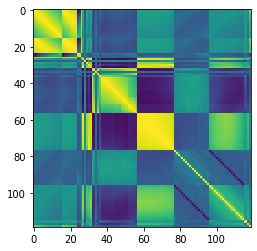

In [74]:
plt.imshow(df_normalised.corr())
plt.show()

In [76]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape)

(909, 1, 118) (909, 1)


### Defining our model

In [126]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Flatten, Activation
from tensorflow.keras.layers import LeakyReLU
# LeakyRelu=keras.layers.LeakyReLU(alpha=0.3)

In [159]:
model = Sequential()
model.add(LSTM(256, input_shape=(1, X_train.shape[2]),return_sequences=True))
model.add(LeakyReLU(alpha=0.3))

model.add(LSTM(128))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.1))

model.add(Dense(98))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.1))

# model.add(LSTM(64, activation=LeakyRelu, return_sequences=True))

model.add(Dense(64))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.1))

model.add(Dense(32))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.1))

model.add(Dense(1, activation=tf.nn.elu))
Adam=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.99, beta_2=0.999, amsgrad=True, decay=0.0001)
SGD = tf.keras.optimizers.SGD(lr=0.003, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=SGD,
              loss='mean_squared_error',)

### Training our model

In [160]:
history=model.fit(X_train, 
                  y_train, 
                  epochs=60,
                  batch_size=64, 
#                   callbacks = [callback],
                  validation_data=(X_test, y_test), 
                  verbose=1,)

Train on 909 samples, validate on 101 samples
Epoch 1/60
909/909 [==============================] - 11s 12ms/sample - loss: 0.9611 - val_loss: 1.3189
Epoch 2/60
909/909 [==============================] - 0s 455us/sample - loss: 0.9516 - val_loss: 1.3033
Epoch 3/60
909/909 [==============================] - 1s 695us/sample - loss: 0.9332 - val_loss: 1.2731
Epoch 4/60
909/909 [==============================] - 1s 575us/sample - loss: 0.9086 - val_loss: 1.2346
Epoch 5/60
909/909 [==============================] - 0s 479us/sample - loss: 0.8766 - val_loss: 1.1809
Epoch 6/60
909/909 [==============================] - 0s 477us/sample - loss: 0.8380 - val_loss: 1.1219
Epoch 7/60
909/909 [==============================] - 0s 419us/sample - loss: 0.7844 - val_loss: 1.0353
Epoch 8/60
909/909 [==============================] - 0s 415us/sample - loss: 0.7138 - val_loss: 0.9039
Epoch 9/60
909/909 [==============================] - 0s 395us/sample - loss: 0.6443 - val_loss: 0.8076
Epoch 10/60
909/90

### Analysing our losses
Note that the results of this section may differ for some people. We have managed to get `val-loss` down to about 0.2.

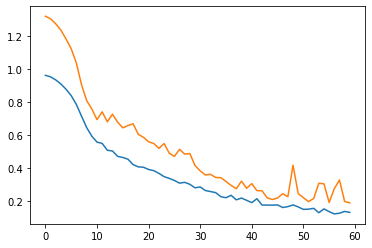

In [161]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

0.1885052155968707

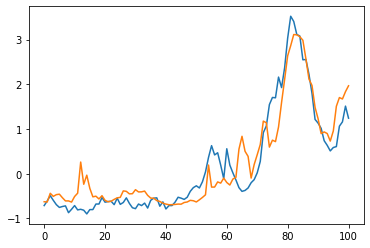

In [162]:
p=model.predict(X_test)
plt.plot(y_test)    
plt.plot(p)
euclid_loss(y_test, p)

In [163]:
model.save('epic-dengue-model')